# Imports & Functions

In [69]:
from datetime import datetime, time
import pandas as pd
# from sodapy import Socrata
import numpy as np 
import ast
import json
import pandasql
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pandas import Series
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import cufflinks as cf
import plotly.plotly as py
plt.rcParams.update({'font.size': 16})

ImportError: 
The plotly.plotly module is deprecated,
please install the chart-studio package and use the
chart_studio.plotly module instead. 


In [2]:
# The start and end times for the fixed bin sizes for binning each datetime object in each row
morningStart = time(6, 0, 0)
morningEnd = time(12,0,0)
afternoonStart = time(12,0,1)
afternoonEnd = time(18,30,0)
nightStart = time(18,31,0)
nightEnd = time(23,59,59)
midnightStart = time(0,0,0)
midnightEnd = time(5,59,0)
springStart = 3
springEnd = 5
summerStart = 6
summerEnd = 8
fallStart = 9
fallEnd = 11
winterStart = 12
winterEnd = 2 

# Time of Day Function
def timeOfDayApplier(dateColumn):
    DatetimeVersion = datetime.strptime(dateColumn,'%m/%d/%Y %I:%M:%S %p') # 'I' accounts for 12-hour format
    
    if morningStart <= DatetimeVersion.time() <= morningEnd:
        return "Morning"
    elif afternoonStart <= DatetimeVersion.time() <= afternoonEnd:
        return "Afternoon/Evening"
    elif nightStart <= DatetimeVersion.time() <= nightEnd:
        return "Night"
    elif midnightStart <= DatetimeVersion.time() <= midnightEnd:
        return "Midnight"


# Season of Year Function
def seasonOfYear(dateColumn):
    DatetimeVersion = datetime.strptime(dateColumn,'%m/%d/%Y %I:%M:%S %p') # 'I' accounts for 12-hour format
     
    if DatetimeVersion.month in [12,1,2]:
        return "Winter"   
    elif springStart <= DatetimeVersion.month <= springEnd:
        return "Spring"
    elif summerStart <= DatetimeVersion.month <= summerEnd:
        return "Summer"
    elif fallStart <= DatetimeVersion.month <= fallEnd:
        return "Fall"

# Day of Week Function
def dayOfWeek(dateColumn):
    DatetimeVersion = datetime.strptime(dateColumn,'%m/%d/%Y %I:%M:%S %p') # 'I' accounts for 12-hour format
     
    if DatetimeVersion.weekday() in [0,1,2,3,4]:
        return "Weekday"   
    else:
        return "Weekend"

# Data Preprocessing

In [3]:
# Connecting police districts to community area names off of community area coddes
CommunityToPoliceDistrict = []
with open('PoliceDistrictToCommunityNamesOutput.txt') as fp:
    for line in fp:
        communityNum, communityName, policeDist  = line.strip().split(":")
        communityName = communityName.strip()
        CommunityToPoliceDistrict.append({"Community_Area": float(communityNum), "Community_Name": communityName,
                                         "Police_District": policeDist})

# Creates a dataframe with 3 columns: CommunityArea, CommunityName, PoliceDistrict
CommunityPoliceDistrictDF = pd.DataFrame(CommunityToPoliceDistrict)

In [43]:
community_areas = CommunityPoliceDistrictDF['Community_Name'].tolist() # list of community areas
colors = []

NUM_COLORS = 77
cm = plt.get_cmap('gist_rainbow')

# assigns a unique color for each community area for easier graphing
for i in range(len(community_areas)):
    colors.append(cm(i//3*3.0/NUM_COLORS))
    
dictionary = dict(zip(community_areas, colors))

In [5]:
# Crime data from from the crimes csv with community area names for where the crime occured
# specify datatypes for further preprocessing and analysis
CrimeData = pd.read_csv("Crimes2001_2020.csv",
                       dtype={'ID': int, 'Case Number' : str, 'Date' : str, 'Block' : str, 
                             'IUCR' : str, 'Primary Type' : str, 'Description' : str, 
                             'Location Description' : str, 'Arrest' : str, 'Domestic' : str, 'Beat' : str, 
                             'District' : float, 'Ward' : float, 'Community Area' : float, 'FBI Code' : str, 
                              'X Coordinate' : str, 'Y Coordinate' : str, 'Year' : int,'Updated On' : str,
                             'Latitude' : str, 'Longitude' : str, 'Location' : str}, )

# rename columns with spaces to underscores to allow for SQL querying
CrimeData.rename(columns = {'Community Area':'Community_Area'}, inplace = True)

# drop unnecessary columns
CrimeData = CrimeData.drop(['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location'], axis = 1)
SampledCrimeData = CrimeData

# Join the crime data with the communityName and PoliceDistrict dataframe by doing a left join on community area
SampledCrimeData = SampledCrimeData.join(CommunityPoliceDistrictDF.set_index('Community_Area'), on='Community_Area')

In [6]:
# Used to Extract the data from the Socio Economic CSV File 
# To train our program what specific communities are better or worse off than average
# We can use .describe() to find the benchmark levels of poverty per community. Compare community to the average and give weightage 
columns = [
'Community_Area',
'community_area_name', 
'%_housing_crowded', 
'%_households_below_poverty', 
'%_age16_unemployed',
'%_age25_nohighschool',
'%_not_working_age',
'per_capita_income',
'hardship_index']
SocioeconomicData = pd.read_csv("SocioeconomicData.csv")
SocioeconomicData.columns = columns # set columns equal to the specified array 

# apply a left join on the sample crime data on socioeconomic data on communityArea.
SampledSocioeconomicCrimeData = SampledCrimeData.join(SocioeconomicData.set_index('Community_Area'), on='Community_Area')

In [7]:
# Adding census data to the sampled socioeconomic crime data df
CensusData = pd.read_csv("census_data.csv", sep ='\t')

# rename columns that have spaces to underscores
CensusData = CensusData.rename(columns={'Average Household Size' : "Average_Household_Size",
                                       'Vacant Housing Units' : 'Vacant_Households'})

# merge the census data with the crime data on communityArea.
SampledSocioeconomicCrimeData = SampledSocioeconomicCrimeData.merge(CensusData, on='Community_Area', how='left')

# drop all unnecessary columns from the dataframe to improve speed and space efficiency
SampledSocioeconomicCrimeData = SampledSocioeconomicCrimeData.drop(
    ['Arrest', 'Domestic', 'FBI Code', 'IUCR', 'Beat', 'Ward',
    'Case Number', 'Block', 'Primary Type', 'Description','Location Description', 'District', 'Year',
       'Updated On', 'community_area_name', 'Police_District','Not Hispanic or Latino, American Indian and Alaska Native alone','Not Hispanic or Latino, Native Hawaiian and Other Pacific Islander alone', 
     'Not Hispanic or Latino, Some Other Race alone','Not Hispanic or Latino, Two or More Races'], axis = 1)


# DROP ALL ROWS THAT HAVE A NaN VALUE IN THEIR ROW FROM THE DATAFRAME. Handles for the NULL cases from the raw data.
SampledSocioeconomicCrimeData = SampledSocioeconomicCrimeData.dropna()
# rename columns with spaces
SampledSocioeconomicCrimeData.rename(columns={'Not Hispanic or Latino, White alone' : 'Num_White',
       'Not Hispanic or Latino, Black or African American alone' : "Num_African_American",
       'Not Hispanic or Latino, Asian alone' : "Num_Asian",'Hispanic or Latino' : "Num_Hispanic"}, inplace = True)


In [8]:
# Add three new columns that aggregate the date attribute to timeofday, season, and day of week. 
SampledSocioeconomicCrimeData['TimeOfDay'] = SampledSocioeconomicCrimeData['Date'].map(timeOfDayApplier)
SampledSocioeconomicCrimeData['Season'] = SampledSocioeconomicCrimeData['Date'].map(seasonOfYear)
SampledSocioeconomicCrimeData['Weekday_Weekend'] = SampledSocioeconomicCrimeData['Date'].map(dayOfWeek)

# Add three new columns that aggregate the date attribute to timeofday, season, and day of week. 
SampledCrimeData['TimeOfDay'] = SampledCrimeData['Date'].map(timeOfDayApplier)
SampledCrimeData['Season'] = SampledCrimeData['Date'].map(seasonOfYear)
SampledCrimeData['Weekday/Weekend'] = SampledCrimeData['Date'].map(dayOfWeek)

In [9]:
# Putting auxiliary data in bins
DiscCutSocioeconomicCrimeData = SampledSocioeconomicCrimeData.copy()
DiscCutSocioeconomicCrimeData.columns

# Using equal bin width
c = ['%_housing_crowded','%_households_below_poverty', '%_age16_unemployed',
       '%_age25_nohighschool', '%_not_working_age', 'per_capita_income',
       'hardship_index', 'Total Population', 'Num_White',
       'Num_African_American', 'Num_Asian', 'Num_Hispanic',
       'Male: Under 5 years old', 'Male: 5 to 9 years', 'Male: 10 to 14 years',
       'Male: 15 to 17 years', 'Male: 18 and 19 years', 'Male: 20 years',
       'Male: 21 years', 'Male: 22 to 24 years', 'Male: 25 to 29 years',
       'Male: 30 to 34 years', 'Male: 35 to 39 years', 'Male: 40 to 44 years',
       'Male: 45 to 49 years', 'Male: 50 to 54 years', 'Male: 55 to 59 years',
       'Male: 60 and 61 years', 'Male: 62 to 64 years',
       'Male: 65 and 66 years', 'Male: 67 to 69 years', 'Male: 70 to 74 years',
       'Male: 75 to 79 years', 'Male: 80 to 84 years',
       'Male: 85 years and over', 'Female: Under 5 years old',
       'Female: 5 to 9 years', 'Female: 10 to 14 years',
       'Female: 15 to 17 years', 'Female: 18 and 19 years', 'Female: 20 years',
       'Female: 21 years', 'Female: 22 to 24 years', 'Female: 25 to 29 years',
       'Female: 30 to 34 years', 'Female: 35 to 39 years',
       'Female: 40 to 44 years', 'Female: 45 to 49 years',
       'Female: 50 to 54 years', 'Female: 55 to 59 years',
       'Female: 60 and 61 years', 'Female: 62 to 64 years',
       'Female: 65 and 66 years', 'Female: 67 to 69 years',
       'Female: 70 to 74 years', 'Female: 75 to 79 years',
       'Female: 80 to 84 years', 'Female: 85 years and over', 'Median Age',
       'Total Households', 'Average_Household_Size', 'Total Housing Units',
       'Occupied Housing Units', 'Vacant_Households',
       'Occupied Housing Units.1', 'Owned with a mortgage or a loan',
       'Owned free and clear', 'Renter occupied', 'Male_Female_Ratio ']

# bins each attribute into equal width binning --- low ,medium, and high
for col in DiscCutSocioeconomicCrimeData[c]:
    DiscCutSocioeconomicCrimeData[col] = pd.cut(DiscCutSocioeconomicCrimeData[col],bins=3, labels=['low', 'med', 'high'])
DiscCutSocioeconomicCrimeData.head()

,ID,Date,Community_Area,Community_Name_x,%_housing_crowded,%_households_below_poverty,%_age16_unemployed,%_age25_nohighschool,%_not_working_age,per_capita_income,...,Occupied Housing Units,Vacant_Households,Occupied Housing Units.1,Owned with a mortgage or a loan,Owned free and clear,Renter occupied,Male_Female_Ratio,TimeOfDay,Season,Weekday_Weekend
0,11034701,01/01/2001 11:00:00 AM,45,AVALON PARK,low,low,med,low,high,low,...,low,low,low,low,low,low,low,Morning,Winter,Weekday
1,11227287,10/08/2017 03:00:00 AM,73,WASHINGTON HEIGHTS,low,low,med,low,high,low,...,low,low,low,low,low,low,low,Midnight,Fall,Weekend
2,11227583,03/28/2017 02:00:00 PM,70,ASHBURN,low,low,low,low,med,low,...,low,low,low,med,low,low,med,Afternoon/Evening,Spring,Weekday
3,11227293,09/09/2017 08:17:00 PM,42,WOODLAWN,low,med,med,low,med,low,...,low,low,low,low,low,low,low,Night,Fall,Weekend
4,11227634,08/26/2017 10:00:00 AM,32,LOOP,low,low,low,low,low,high,...,low,med,low,low,low,low,med,Morning,Summer,Weekend


In [10]:
# Prepare data for pandasql statement
SampledSocioeconomicCrimeData = SampledSocioeconomicCrimeData.drop(['Community_Name_y'], axis = 1)
SampledSocioeconomicCrimeData.rename(columns = {'Community_Name_x':'Community_Name', '%_housing_crowded':'percent_housing_crowded',
                                   '%_households_below_poverty': 'percent_households_below_poverty',
                                   '%_age16_unemployed' : 'percent_age16_unemployed',
                                   '%_age25_nohighschool' : 'percent_age25_nohighschool'}, inplace = True)

In [11]:
# SQL Queries that help us aggregate and query through the crime dataframe. The returned result is at the 
# community level, along with the timeOfDay, Season, and dayOfWeek attributes. All the important/relevant 
# predictor attributes are extracted and selected within the query.

query = """
WITH cr AS
(
    SELECT DISTINCT
    Community_Name
    ,Community_Area
    ,percent_age16_unemployed
    ,percent_households_below_poverty
    ,percent_age25_nohighschool
    ,per_capita_income
    ,hardship_index
    ,Average_Household_Size
    ,Vacant_Households
    ,Num_Asian
    ,Num_African_American
    ,Num_White
    ,TimeOfDay
    ,Season
    ,Weekday_Weekend
    ,COUNT(*) AS crimes
    
    FROM SampledSocioeconomicCrimeData
    GROUP BY Community_Name, TimeOfDay, Season, Weekday_Weekend
)
SELECT 
    cr.Community_Name
    ,cr.Community_Area
    ,cr.percent_age16_unemployed
    ,cr.percent_households_below_poverty
    ,cr.percent_age25_nohighschool
    ,cr.per_capita_income
    ,cr.hardship_index
    ,cr.Average_Household_Size
    ,cr.Vacant_Households
    ,cr.Num_Asian
    ,cr.Num_African_American
    ,cr.Num_White
    ,cr.TimeOfDay
    ,cr.Season
    ,cr.Weekday_Weekend
    ,cr.crimes Num_Crimes
FROM cr
ORDER BY Num_Crimes DESC, cr.Community_Name;
"""

query2 = """
WITH cr AS
(
    SELECT DISTINCT
    Community_Name
    ,percent_age16_unemployed
    ,percent_households_below_poverty
    ,percent_age25_nohighschool
    ,per_capita_income
    ,hardship_index
    ,Average_Household_Size
    ,Vacant_Households
    ,Num_Asian
    ,Num_African_American
    ,Num_White
    , COUNT(*) AS crimes
    
    FROM SampledSocioeconomicCrimeData
    GROUP BY Community_Name
)
SELECT 
    cr.Community_Name
    ,cr.percent_age16_unemployed
    ,cr.percent_households_below_poverty
    ,cr.percent_age25_nohighschool
    ,cr.per_capita_income
    ,cr.hardship_index
    ,cr.Average_Household_Size
    ,cr.Vacant_Households
    ,cr.Num_Asian
    ,cr.Num_African_American
    ,cr.Num_White
    ,cr.crimes Num_Crimes
    
FROM cr
ORDER BY Num_Crimes DESC, cr.Community_Name;
"""

# uses pandasql to query thru the Dataframe and returns the result as a DF.
AggregatedDataframe = pandasql.sqldf(query, globals())
DataframeToVisualize = pandasql.sqldf(query2, globals())


# An example set of rows for a specific community area for example
print("Sample aggregated data: \n")
print(AggregatedDataframe[(AggregatedDataframe['Community_Name'] == "AUSTIN") & (AggregatedDataframe['TimeOfDay'] == "Midnight")
                         & (AggregatedDataframe['Season'] == "Winter")].head())
print("# CRIMES TOTAL: ",sum(AggregatedDataframe.Num_Crimes))

Sample aggregated data: 

    Community_Name  Community_Area  percent_age16_unemployed  \
0           AUSTIN            25.0                      22.6   
574         AUSTIN            25.0                      22.6   

     percent_households_below_poverty  percent_age25_nohighschool  \
0                                28.6                        24.4   
574                              28.6                        24.4   

     per_capita_income  hardship_index  Average_Household_Size  \
0              15957.0            73.0                    2.96   
574            15957.0            73.0                    2.96   

     Vacant_Households  Num_Asian  Num_African_American  Num_White TimeOfDay  \
0               5422.0      573.0               83837.0     4364.0  Midnight   
574             5422.0      573.0               83837.0     4364.0  Midnight   

     Season Weekday_Weekend  Num_Crimes  
0    Winter         Weekday          33  
574  Winter         Weekend           4  
# CRIME

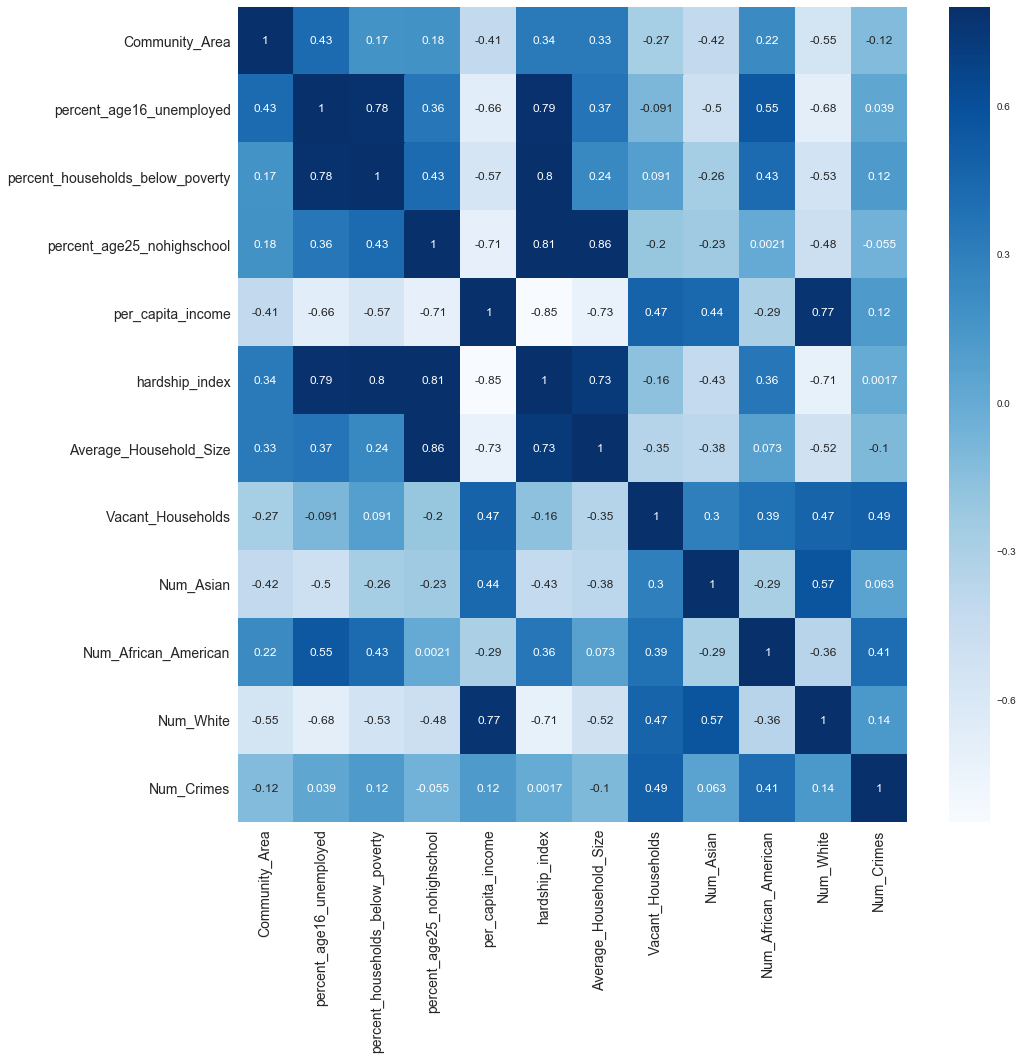

In [48]:
import seaborn as sns
%matplotlib inline

# creates a numeric matrix of the correlations between the entire dataframe
corrmat = AggregatedDataframe.corr()

# plot size of 8 x 8 
fig = plt.figure(figsize = (15, 15))

# sets font size of seaborn visual 
sns.set(font_scale=1)

# creates the heatmap 
sns.heatmap(corrmat, vmax = 0.8, annot=True, cmap="Blues")

# x and y tick labels font size
plt.yticks(rotation=0, fontsize=14)
plt.xticks(rotation=90, fontsize=14)
plt.show()

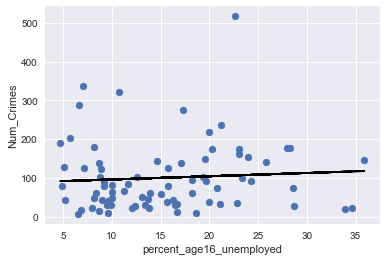

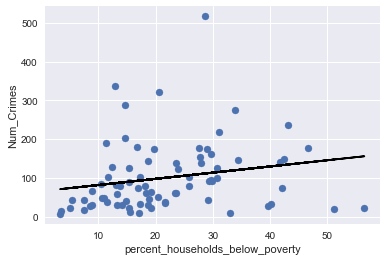

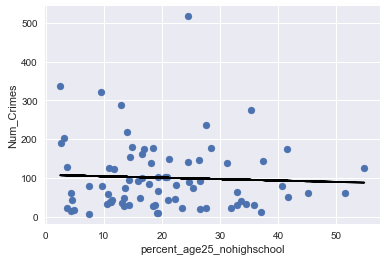

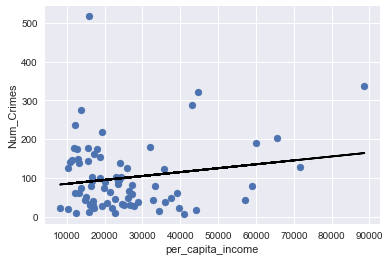

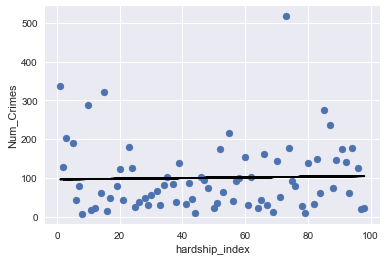

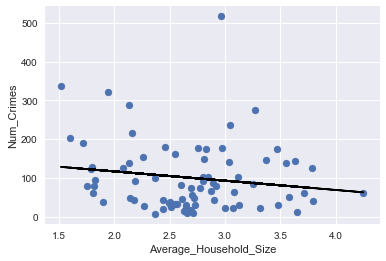

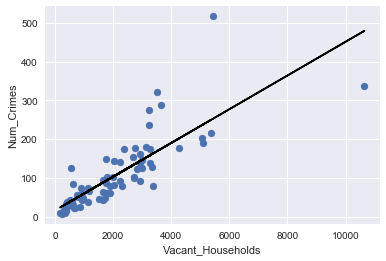

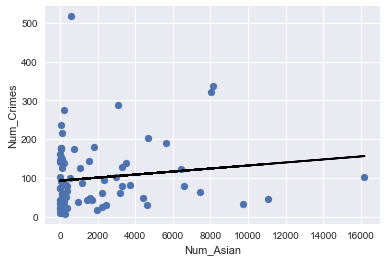

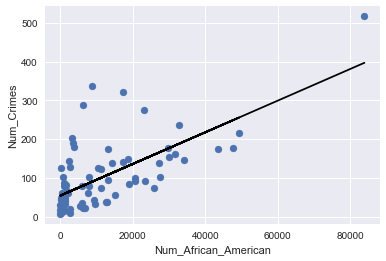

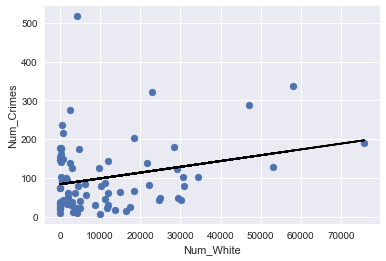

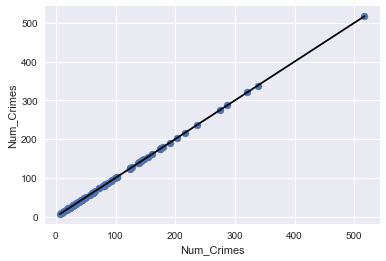

In [65]:
predictorColumns = DataframeToVisualize.columns
%matplotlib inline

# prints the correlation between each column in the Dataframe to visualize AND # of crimes.
for column in predictorColumns: 
    # makes sure discrete attributes are not counted for 
    if column not in ['TimeOfDay', 'Season', 'Community_Name']:
        # plots the scatter 
        plt.scatter(x=DataframeToVisualize[column], y=DataframeToVisualize['Num_Crimes'])
        # plots the linear line that does through the points 
        m, b = np.polyfit(DataframeToVisualize[column],DataframeToVisualize['Num_Crimes'], 1)
        plt.plot(DataframeToVisualize[column], m*DataframeToVisualize[column] + b,color='black')
        # ssets font size 
        plt.xlabel(column, fontsize=11)
        plt.ylabel("Num_Crimes", fontsize=11)
        plt.figure(figsize=(15,15))
        plt.show()

In [14]:
# For finding the most common type of crime
PrimaryCrimeTypes = SampledCrimeData['Primary Type'].unique()
PrimaryCrimeTypeCounts = pd.DataFrame()
for c in PrimaryCrimeTypes:
    df = SampledCrimeData[SampledCrimeData['Primary Type']==c]
    PrimaryCrimeTypeCounts[c] = df['Community_Name'].value_counts().sort_index()

# Contains counts of each primary type of crime for each community area

# sets None values to 0
PrimaryCrimeTypeCounts = PrimaryCrimeTypeCounts.fillna(0) 
print("Crime Counts by Type of Crime by Community Area")
PrimaryCrimeTypeCounts

Crime Counts by Type of Crime by Community Area


,DECEPTIVE PRACTICE,CRIM SEXUAL ASSAULT,BURGLARY,THEFT,OFFENSE INVOLVING CHILDREN,CRIMINAL DAMAGE,OTHER OFFENSE,NARCOTICS,SEX OFFENSE,BATTERY,...,NON-CRIMINAL,PUBLIC PEACE VIOLATION,LIQUOR LAW VIOLATION,PROSTITUTION,INTIMIDATION,ARSON,INTERFERENCE WITH PUBLIC OFFICER,GAMBLING,STALKING,KIDNAPPING
ALBANY PARK,11,0.0,1.0,18,3.0,4.0,2.0,3.0,2.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARCHER HEIGHTS,4,0.0,0.0,10,4.0,1.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ASHBURN,21,1.0,7.0,18,5.0,7.0,3.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
AUBURN GRESHAM,39,5.0,5.0,41,9.0,9.0,7.0,21.0,1.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
AUSTIN,81,10.0,8.0,72,15.0,14.0,26.0,138.0,11.0,50.0,...,1.0,2.0,0.0,15.0,0.0,0.0,1.0,2.0,0.0,1.0
AVALON PARK,12,2.0,0.0,6,0.0,2.0,1.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AVONDALE,15,4.0,2.0,21,1.0,2.0,4.0,3.0,0.0,6.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
BELMONT CRAGIN,13,4.0,7.0,42,9.0,7.0,7.0,6.0,8.0,5.0,...,1.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
BEVERLY,8,0.0,1.0,6,0.0,1.0,1.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BRIDGEPORT,4,0.0,2.0,14,1.0,8.0,2.0,3.0,2.0,6.0,...,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0


In [15]:
# Contains the most common type of crime for each community area
MostCommonPrimaryCrimeType = pd.DataFrame(PrimaryCrimeTypeCounts.idxmax(axis=1))
MostCommonPrimaryCrimeType.columns = ['Primary Type']
print(MostCommonPrimaryCrimeType)

                                      Primary Type
ALBANY PARK                                  THEFT
ARCHER HEIGHTS                               THEFT
ASHBURN                         DECEPTIVE PRACTICE
AUBURN GRESHAM                               THEFT
AUSTIN                                   NARCOTICS
AVALON PARK                     DECEPTIVE PRACTICE
AVONDALE                                     THEFT
BELMONT CRAGIN                               THEFT
BEVERLY                         DECEPTIVE PRACTICE
BRIDGEPORT                                   THEFT
BRIGHTON PARK                                THEFT
BURNSIDE                        DECEPTIVE PRACTICE
CALUMET HEIGHTS                 DECEPTIVE PRACTICE
CHATHAM                         DECEPTIVE PRACTICE
CHICAGO LAWN                    DECEPTIVE PRACTICE
CLEARING                                     THEFT
DOUGLAS                                      THEFT
DUNNING                                      THEFT
EAST GARFIELD PARK             

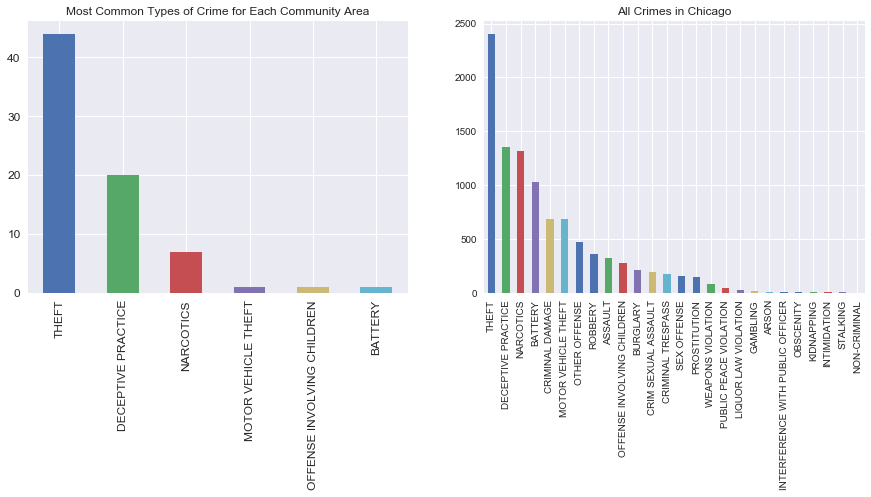

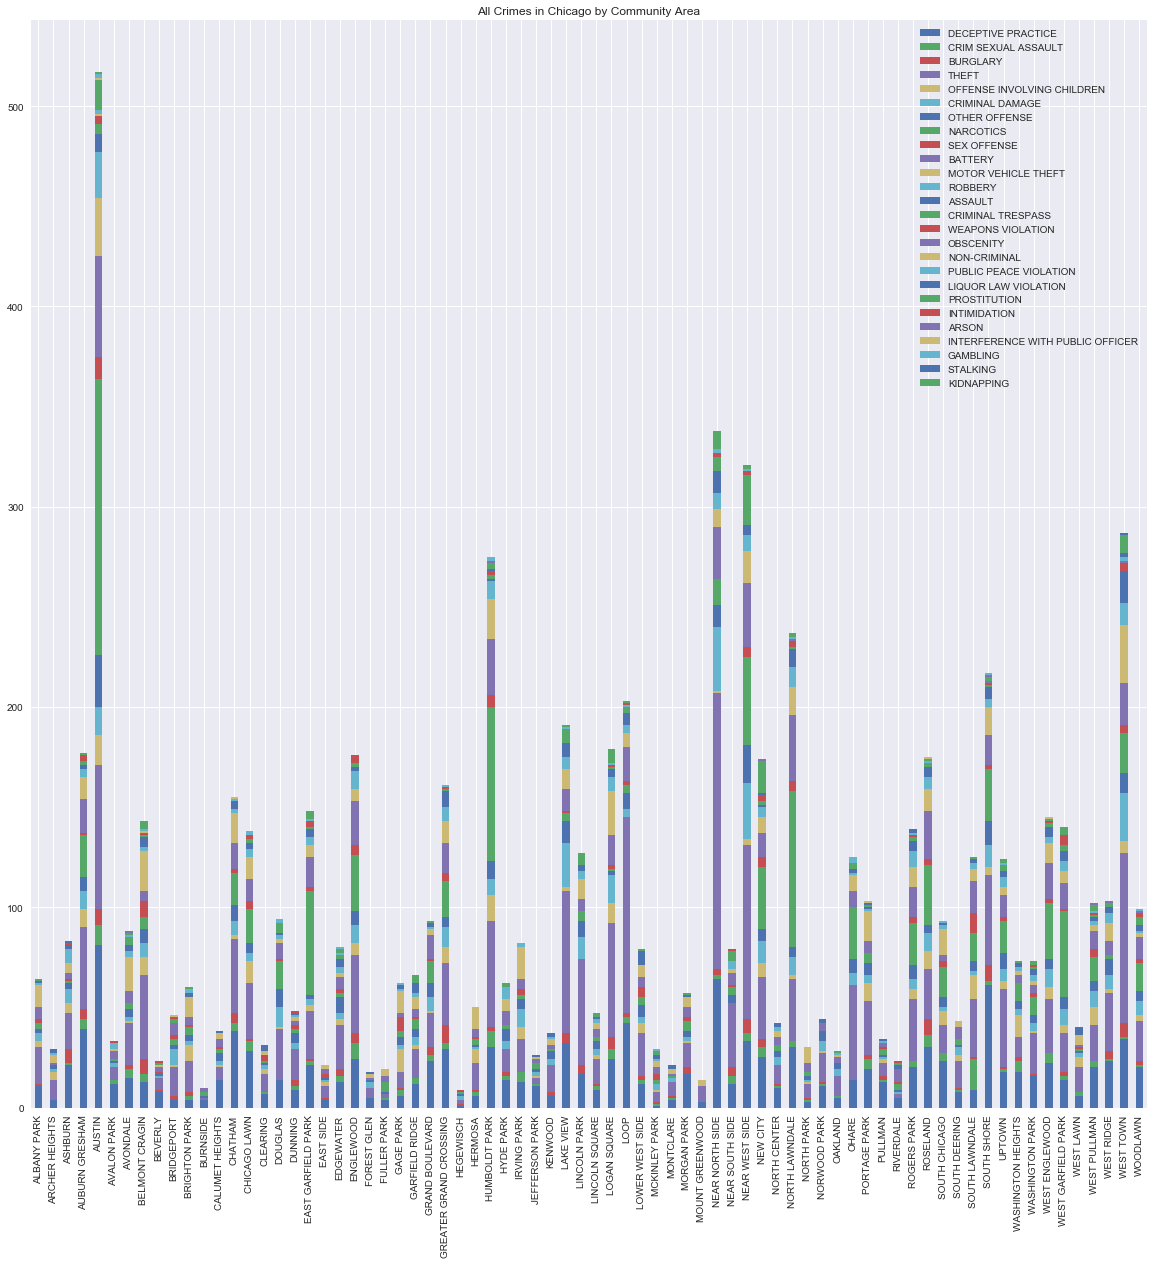

In [71]:
plt.subplot(1, 2, 1)

# Sums the most common type of crime for all community areas
TopPrimaryCrimeTypeCounts = MostCommonPrimaryCrimeType['Primary Type'].value_counts()
TopPrimaryCrimeTypeCounts.plot(kind='bar', title = 'Most Common Types of Crime for Each Community Area', figsize=(15,5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(1, 2, 2)

# Sum of all of the crimes in Chicago
SampledCrimeData['Primary Type'].value_counts().plot(kind='bar', title = 'All Crimes in Chicago', figsize=(15,5))
plt.show()


PrimaryCrimeTypeCounts.plot.bar(stacked=True, figsize=(20,20), title = 'All Crimes in Chicago by Community Area')
plt.show()

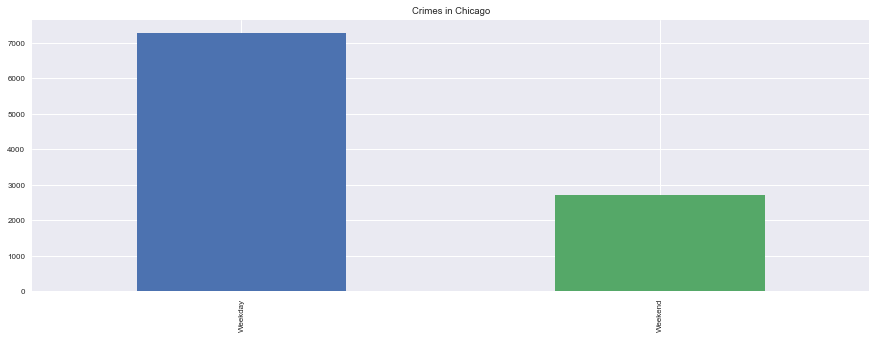

In [17]:
# Sum of all of the crimes in Chicago
SampledCrimeData['Weekday/Weekend'].value_counts().plot(kind='bar', title = 'Crimes in Chicago', figsize=(15,5))
plt.show()

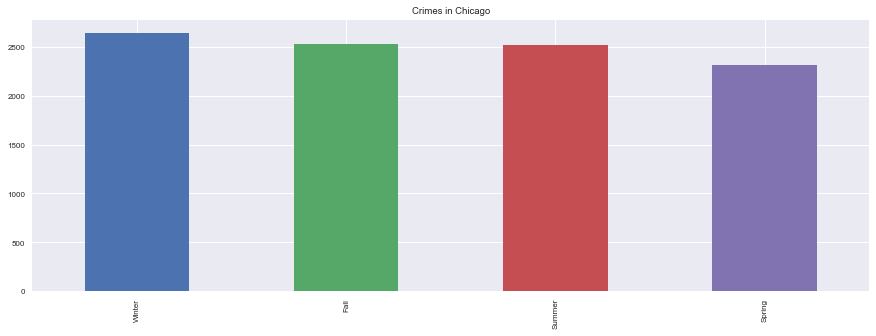

In [18]:
# Sum of all of the crimes in Chicago
SampledCrimeData['Season'].value_counts().plot(kind='bar', title = 'Crimes in Chicago', figsize=(15,5))
plt.show()

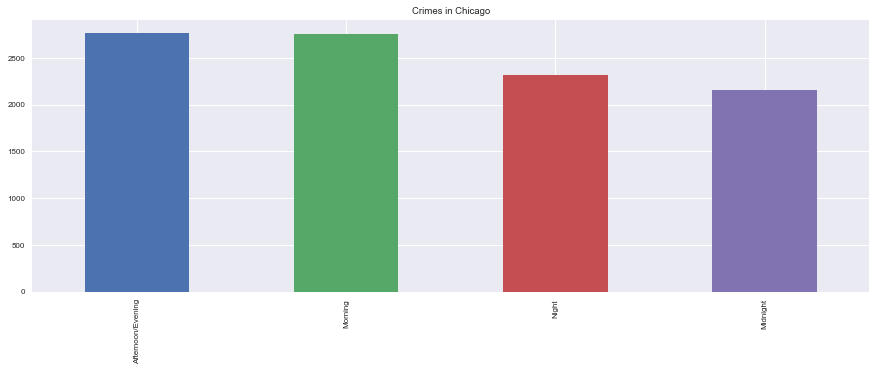

In [19]:
# Sum of all of the crimes in Chicago
SampledCrimeData['TimeOfDay'].value_counts().plot(kind='bar', title = 'Crimes in Chicago', figsize=(15,5))
plt.show()

In [20]:
# For finding the most common time/season/part of week for crimes by primary crime type

# By time
MostCommonCrimeTimeCounts = pd.DataFrame()
CrimeTimes = SampledCrimeData['TimeOfDay'].unique()
for c in CrimeTimes:
    df = SampledCrimeData[SampledCrimeData['TimeOfDay']==c]
    MostCommonCrimeTimeCounts[c] = df['Primary Type'].value_counts().sort_index()
MostCommonCrimeTimeCounts.fillna(0) 
MostCommonCrimeTime = pd.DataFrame(MostCommonCrimeTimeCounts.idxmax(axis=1))
MostCommonCrimeTime.columns = ['TimeOfDay']
print(MostCommonCrimeTime)
    
# By Season
MostCommonCrimeSeasonCounts = pd.DataFrame()
CrimeSesons = SampledCrimeData['Season'].unique()
for c in CrimeSesons:
    df = SampledCrimeData[SampledCrimeData['Season']==c]
    MostCommonCrimeSeasonCounts[c] = df['Primary Type'].value_counts().sort_index()
MostCommonCrimeSeasonCounts.fillna(0)
MostCommonCrimeSeason = pd.DataFrame(MostCommonCrimeSeasonCounts.idxmax(axis=1))
MostCommonCrimeSeason.columns = ['Season']
print(MostCommonCrimeSeason)
    
# By time of week
MostCommonCrimeWeekCounts = pd.DataFrame()
CrimeWeek = SampledCrimeData['Weekday/Weekend'].unique()
for c in CrimeWeek:
    df = SampledCrimeData[SampledCrimeData['Weekday/Weekend']==c]
    MostCommonCrimeWeekCounts[c] = df['Primary Type'].value_counts().sort_index()
MostCommonCrimeWeekCounts.fillna(0)
MostCommonCrimeWeek = pd.DataFrame(MostCommonCrimeWeekCounts.idxmax(axis=1))
MostCommonCrimeWeek.columns = ['Weekday/Weekend']
print(MostCommonCrimeTime)

                                    TimeOfDay
ARSON                                Midnight
ASSAULT                     Afternoon/Evening
BATTERY                     Afternoon/Evening
BURGLARY                    Afternoon/Evening
CRIM SEXUAL ASSAULT                  Midnight
CRIMINAL DAMAGE             Afternoon/Evening
CRIMINAL TRESPASS                       Night
DECEPTIVE PRACTICE                    Morning
GAMBLING                    Afternoon/Evening
INTIMIDATION                          Morning
KIDNAPPING                              Night
LIQUOR LAW VIOLATION                    Night
MOTOR VEHICLE THEFT                     Night
NARCOTICS                   Afternoon/Evening
NON-CRIMINAL                          Morning
OBSCENITY                             Morning
OFFENSE INVOLVING CHILDREN           Midnight
OTHER OFFENSE                         Morning
PROSTITUTION                            Night
PUBLIC PEACE VIOLATION                  Night
ROBBERY                           

In [21]:
# For finding the most common time/season/part of week for crimes by community area

# By time
MostCommonCrimeTimeCountsCA = pd.DataFrame()
CrimeTimesCA = SampledCrimeData['TimeOfDay'].unique()
for c in CrimeTimesCA:
    df = SampledCrimeData[SampledCrimeData['TimeOfDay']==c]
    MostCommonCrimeTimeCountsCA[c] = df['Community_Name'].value_counts().sort_index()
MostCommonCrimeTimeCountsCA.fillna(0) 
MostCommonCrimeTimeCA = pd.DataFrame(MostCommonCrimeTimeCountsCA.idxmax(axis=1))
MostCommonCrimeTimeCA.columns = ['TimeOfDay']
print(MostCommonCrimeTimeCA)
    
# By Season
MostCommonCrimeSeasonCountsCA = pd.DataFrame()
CrimeSesonsCA = SampledCrimeData['Season'].unique()
for c in CrimeSesonsCA:
    df = SampledCrimeData[SampledCrimeData['Season']==c]
    MostCommonCrimeSeasonCountsCA[c] = df['Community_Name'].value_counts().sort_index()
MostCommonCrimeSeasonCountsCA.fillna(0)
MostCommonCrimeSeasonCA = pd.DataFrame(MostCommonCrimeSeasonCountsCA.idxmax(axis=1))
MostCommonCrimeSeasonCA.columns = ['Season']
print(MostCommonCrimeSeasonCA)
    
# By time of week
MostCommonCrimeWeekCountsCA = pd.DataFrame()
CrimeWeekCA = SampledCrimeData['Weekday/Weekend'].unique()
for c in CrimeWeekCA:
    df = SampledCrimeData[SampledCrimeData['Weekday/Weekend']==c]
    MostCommonCrimeWeekCountsCA[c] = df['Community_Name'].value_counts().sort_index()
MostCommonCrimeWeekCountsCA.fillna(0)
MostCommonCrimeWeekCA = pd.DataFrame(MostCommonCrimeWeekCountsCA.idxmax(axis=1))
MostCommonCrimeWeekCA.columns = ['Weekday/Weekend']
print(MostCommonCrimeTimeCA)

                                TimeOfDay
ALBANY PARK                       Morning
ARCHER HEIGHTS                    Morning
ARMOUR SQUARE           Afternoon/Evening
ASHBURN                           Morning
AUBURN GRESHAM                    Morning
AUSTIN                            Morning
AVALON PARK                       Morning
AVONDALE                            Night
BELMONT CRAGIN          Afternoon/Evening
BEVERLY                           Morning
BRIDGEPORT                        Morning
BRIGHTON PARK                     Morning
BURNSIDE                          Morning
CALUMET HEIGHTS                   Morning
CHATHAM                           Morning
CHICAGO LAWN                      Morning
CLEARING                         Midnight
DOUGLAS                 Afternoon/Evening
DUNNING                           Morning
EAST GARFIELD PARK      Afternoon/Evening
EAST SIDE                         Morning
EDGEWATER                           Night
ENGLEWOOD                        M

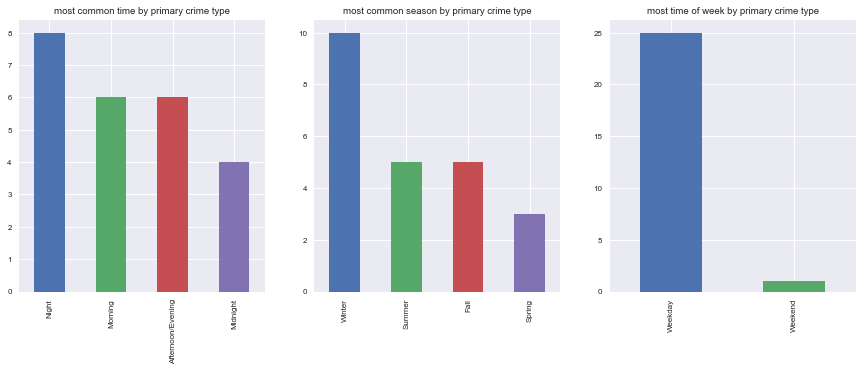

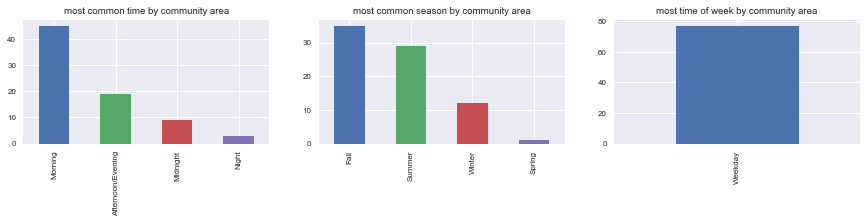

In [22]:
plt.subplot(1, 3, 1)
MostCommonCrimeTimeCounts = MostCommonCrimeTime['TimeOfDay'].value_counts()
MostCommonCrimeTimeCounts.plot(kind='bar', title = 'most common time by primary crime type', figsize=(15,5))

plt.subplot(1, 3, 2)
MostCommonCrimeSeasonCounts = MostCommonCrimeSeason['Season'].value_counts()
MostCommonCrimeSeasonCounts.plot(kind='bar', title = 'most common season by primary crime type', figsize=(15,5))

plt.subplot(1, 3, 3)
MostCommonCrimeWeekCounts = MostCommonCrimeWeek['Weekday/Weekend'].value_counts()
MostCommonCrimeWeekCounts.plot(kind='bar', title = 'most time of week by primary crime type', figsize=(15,5))
plt.show()

plt.subplot(2, 3, 1)
MostCommonCrimeTimeCountsCA = MostCommonCrimeTimeCA['TimeOfDay'].value_counts()
MostCommonCrimeTimeCountsCA.plot(kind='bar', title = 'most common time by community area', figsize=(15,5))

plt.subplot(2, 3, 2)
MostCommonCrimeSeasonCountsCA = MostCommonCrimeSeasonCA['Season'].value_counts()
MostCommonCrimeSeasonCountsCA.plot(kind='bar', title = 'most common season by community area', figsize=(15,5))

plt.subplot(2, 3, 3)
MostCommonCrimeWeekCountsCA = MostCommonCrimeWeekCA['Weekday/Weekend'].value_counts()
MostCommonCrimeWeekCountsCA.plot(kind='bar', title = 'most time of week by community area', figsize=(15,5))
plt.show()

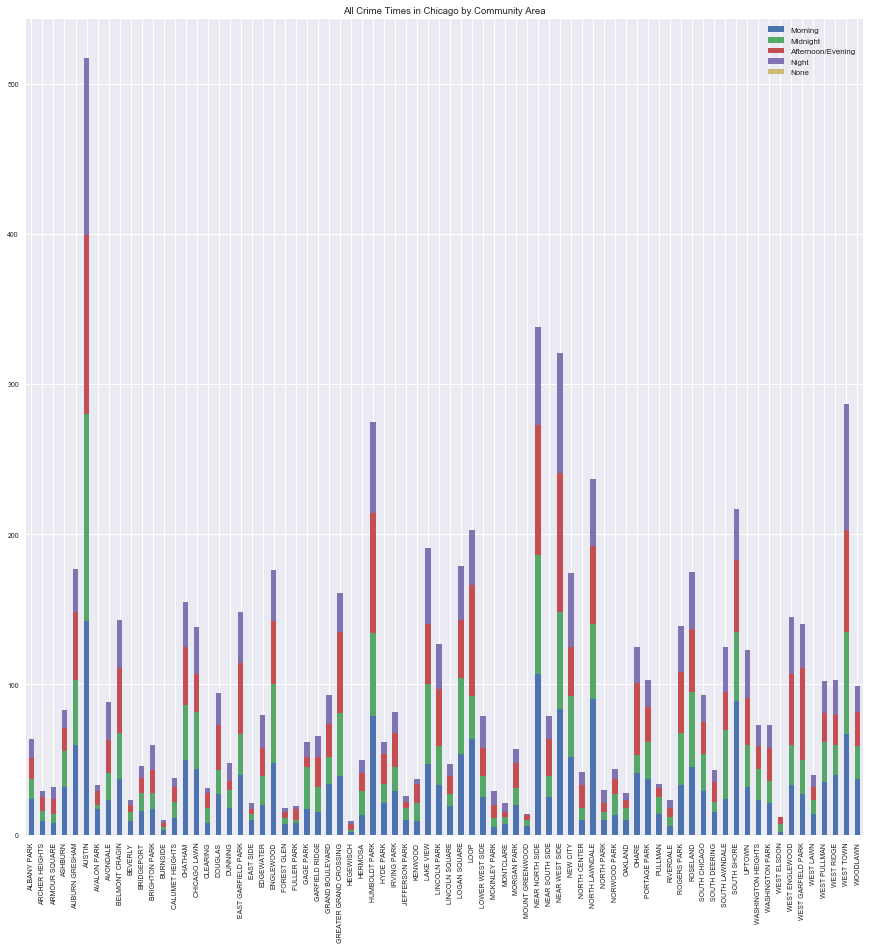

In [23]:
# For seeing all the times crimes are committed by community area
CrimeTimeCountsCA = pd.DataFrame()
for c in CrimeTimesCA:
    df = SampledCrimeData[SampledCrimeData['TimeOfDay']==c]
    CrimeTimeCountsCA[c] = df['Community_Name'].value_counts().sort_index()
CrimeTimeCountsCA.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Times in Chicago by Community Area')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

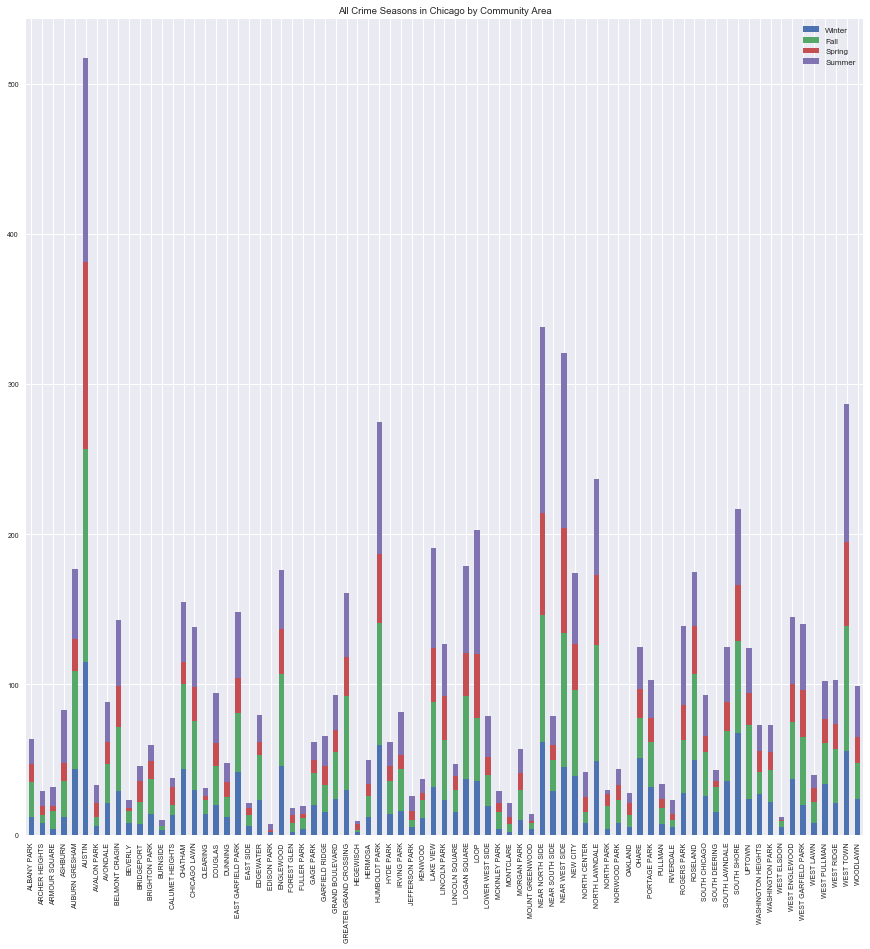

In [24]:
# For seeing all the seasons crimes are committed by community area
CrimeSeasonCountsCA = pd.DataFrame()
for c in CrimeSesonsCA:
    df = SampledCrimeData[SampledCrimeData['Season']==c]
    CrimeSeasonCountsCA[c] = df['Community_Name'].value_counts().sort_index()
CrimeSeasonCountsCA.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Seasons in Chicago by Community Area')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

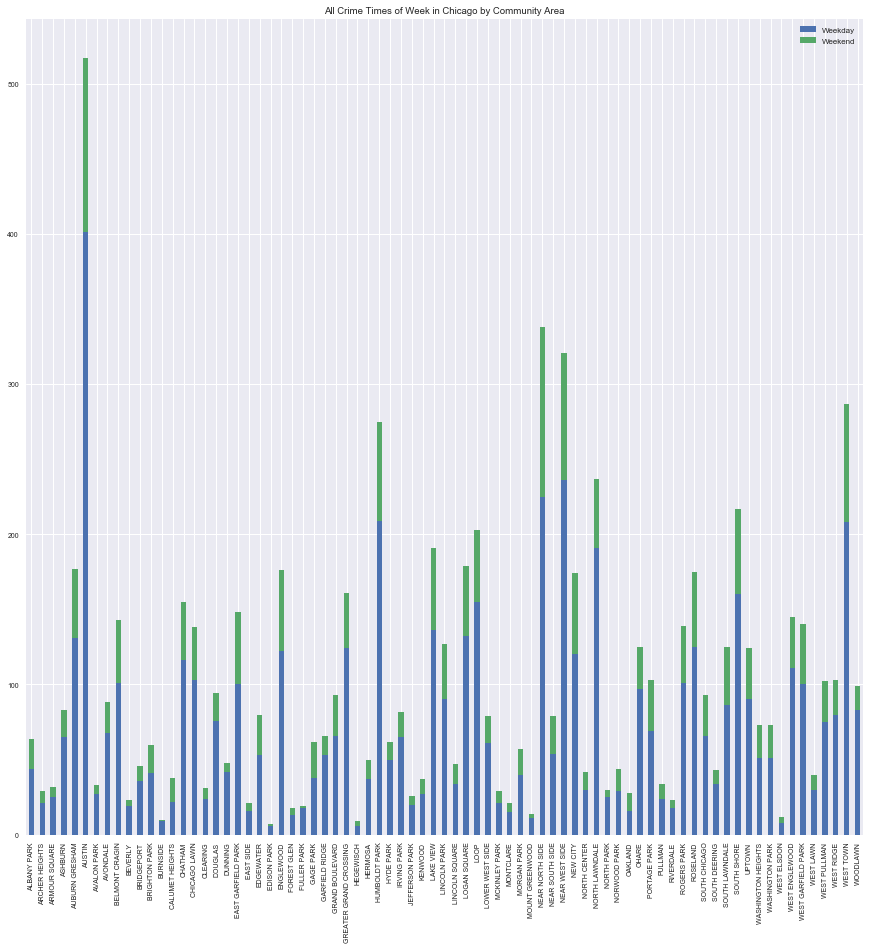

In [25]:
# For seeing all the time of week crimes are committed by community area
CrimeWeekCountsCA = pd.DataFrame()
for c in CrimeWeekCA:
    df = SampledCrimeData[SampledCrimeData['Weekday/Weekend']==c]
    CrimeWeekCountsCA[c] = df['Community_Name'].value_counts().sort_index()
CrimeWeekCountsCA.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Times of Week in Chicago by Community Area')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

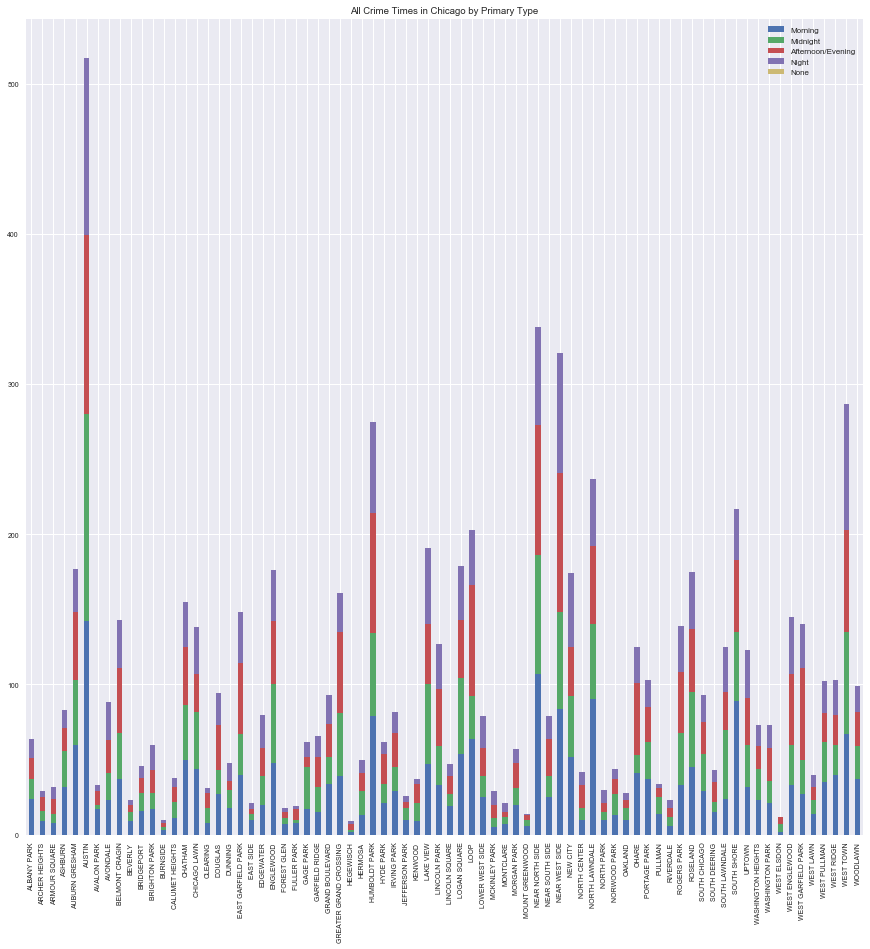

In [26]:
# For seeing all the times crimes are committed by primary type
CrimeTimeCounts = pd.DataFrame()
for c in CrimeTimes:
    df = SampledCrimeData[SampledCrimeData['TimeOfDay']==c]
    CrimeTimeCounts[c] = df['Community_Name'].value_counts().sort_index()
CrimeTimeCounts.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Times in Chicago by Primary Type')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

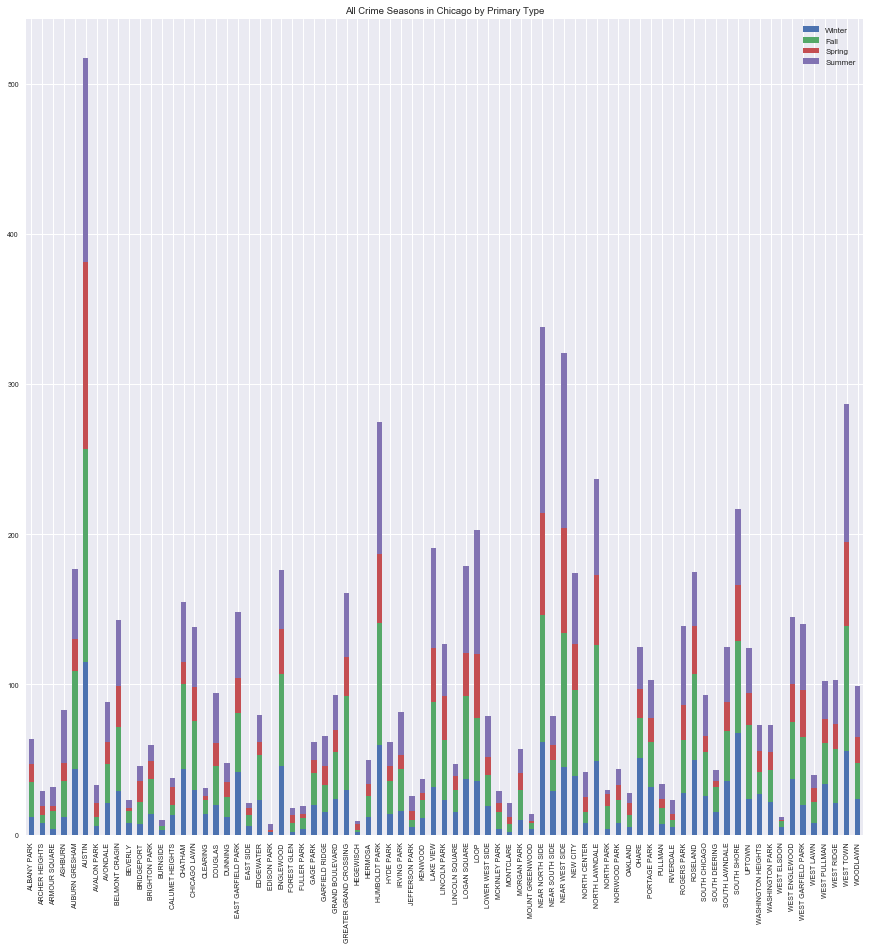

In [27]:
# For seeing all the seasons crimes are committed by primary type
CrimeSeasonCounts = pd.DataFrame()
for c in CrimeSesons:
    df = SampledCrimeData[SampledCrimeData['Season']==c]
    CrimeSeasonCounts[c] = df['Community_Name'].value_counts().sort_index()
CrimeSeasonCounts.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Seasons in Chicago by Primary Type')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

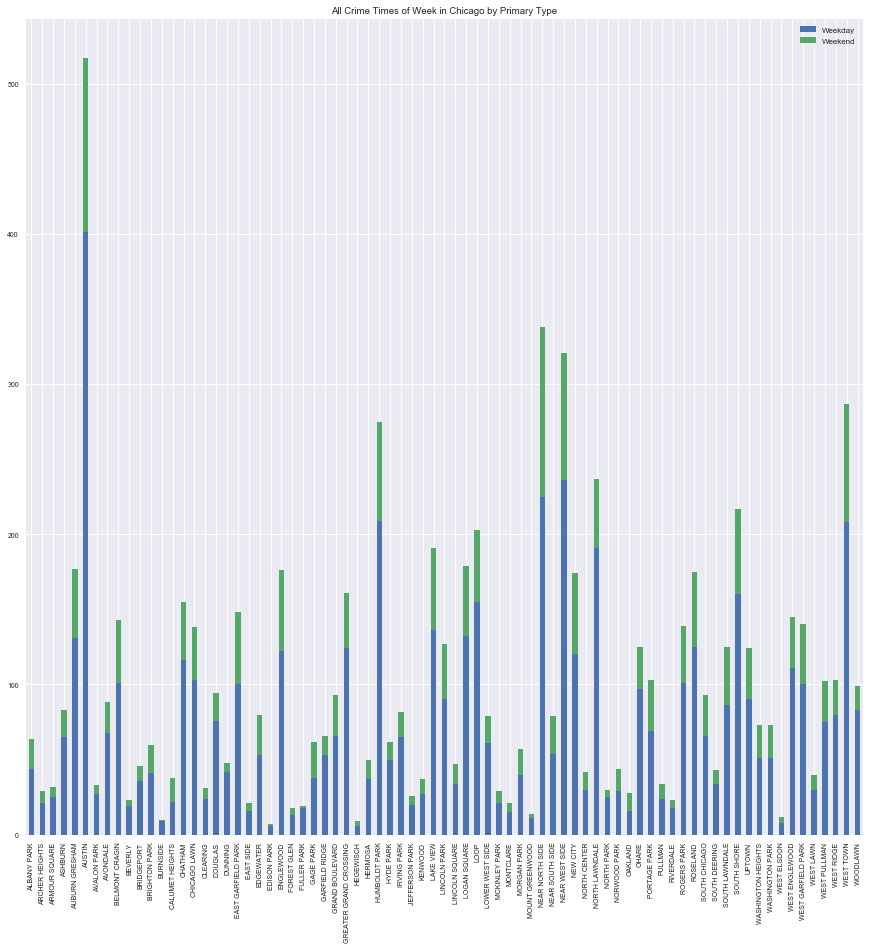

In [28]:
# For seeing all the time of week crimes are committed by primary type
CrimeWeekCounts = pd.DataFrame()
for c in CrimeWeek:
    df = SampledCrimeData[SampledCrimeData['Weekday/Weekend']==c]
    CrimeWeekCounts[c] = df['Community_Name'].value_counts().sort_index()
CrimeWeekCounts.plot.bar(stacked=True, figsize=(15,15), title = 'All Crime Times of Week in Chicago by Primary Type')

plt.yticks(rotation=0, fontsize=7)
plt.xticks(rotation=90, fontsize=7)
plt.show()

# Dimensionality Reduction

In [29]:
# Converting from percentages
crimeDR = SampledSocioeconomicCrimeData.copy()

count = SampledCrimeData.groupby('Community_Name').count()
count = pd.DataFrame(count['ID'])
count.columns = ['crimes']
count = count.sort_index()

crimeDR = crimeDR[['Community_Name','percent_housing_crowded',
       'percent_households_below_poverty', 'percent_age16_unemployed',
       'percent_age25_nohighschool', 'hardship_index', 'Total Population','Vacant_Households', 'TimeOfDay', 'Season', 'Weekday_Weekend']]

crimeDR[['percent_housing_crowded',
       'percent_households_below_poverty', 'percent_age16_unemployed',
       'percent_age25_nohighschool']] /= 100 

crimeDR['percent_housing_crowded'] *=  crimeDR['Total Population']
crimeDR['percent_households_below_poverty'] *=  crimeDR['Total Population']
crimeDR['percent_age16_unemployed'] *=  crimeDR['Total Population']
crimeDR['percent_age25_nohighschool'] *=  crimeDR['Total Population']

crimeDR.columns = ['Community_Name','num_housing_crowded',
       'num_households_below_poverty', 'num_age16_unemployed',
       'num_age25_nohighschool', 'hardship_index', 'Total Population','Vacant_Households', 'TimeOfDay', 'Season', 'Weekday_Weekend']

community_areas = MostCommonPrimaryCrimeType.index.tolist()
crimeDR = crimeDR[crimeDR['Community_Name'].isin(community_areas)]
crimeDR = crimeDR.set_index('Community_Name')
crimeDR['num_crimes'] = count['crimes']
# crimeDR['Weekday_Weekend'] = count['Weekday_Weekend']
# crimeDR['Season'] = count['Season']
# crimeDR['TimeOfDay'] = count['TimeOfDay']
crimeDR = crimeDR.loc[~crimeDR.index.duplicated(keep='first')]

crimeDR.head()

# convert all discrete values into numbers to feed into the PCA tool.
crimeDR.loc[crimeDR['Season'] == "Winter", 'Season'] = 1
crimeDR.loc[crimeDR['Season'] == "Spring", 'Season'] = 2
crimeDR.loc[crimeDR['Season'] == "Summer", 'Season'] = 3
crimeDR.loc[crimeDR['Season'] == "Fall", 'Season'] = 4

crimeDR.loc[crimeDR['TimeOfDay'] == "Morning", 'TimeOfDay'] = 1
crimeDR.loc[crimeDR['TimeOfDay'] == "Afternoon/Evening", 'TimeOfDay'] = 2
crimeDR.loc[crimeDR['TimeOfDay'] == "Night", 'TimeOfDay'] = 3
crimeDR.loc[crimeDR['TimeOfDay'] == "Midnight", 'TimeOfDay'] = 4

crimeDR.loc[crimeDR['Weekday_Weekend'] == "Weekday", 'Weekday_Weekend'] = 1
crimeDR.loc[crimeDR['Weekday_Weekend'] == "Weekend", 'Weekday_Weekend'] = 0

# PCA
pca = PCA(n_components=2)
pca.fit(crimeDR.values)

projected = pca.transform(crimeDR)
projected = pd.DataFrame(projected, columns=['pc1','pc2'], index=crimeDR.index)
crimeDR

,num_housing_crowded,num_households_below_poverty,num_age16_unemployed,num_age25_nohighschool,hardship_index,Total Population,Vacant_Households,TimeOfDay,Season,Weekday_Weekend,num_crimes
Community_Name,,,,,,,,,,,
AVALON PARK,142.590,1751.820,2149.035,1079.610,41.0,10185.0,371.0,1,1,1,33
WASHINGTON HEIGHTS,291.423,4477.317,5510.544,3629.541,48.0,26493.0,883.0,4,4,0,73
ASHBURN,1643.240,4272.424,4806.477,7271.337,37.0,41081.0,609.0,2,2,1,83
WOODLAWN,688.460,7288.180,5555.160,3917.100,58.0,23740.0,2714.0,3,4,0,99
LOOP,439.245,4304.601,1669.131,907.773,3.0,29283.0,5063.0,1,3,0,203
GREATER GRAND CROSSING,1173.672,9650.192,7498.460,5379.330,66.0,32602.0,2932.0,4,1,0,161
WEST LAWN,1934.590,4969.895,3202.080,11207.280,56.0,33355.0,596.0,4,1,1,40
SOUTH LAWNDALE,12051.776,24341.416,12527.504,43449.824,96.0,79288.0,2977.0,4,1,0,125
LOGAN SQUARE,2329.312,12228.888,5968.862,10773.068,23.0,72791.0,3134.0,1,3,1,179


Text(0.5,1,'2nd PC')

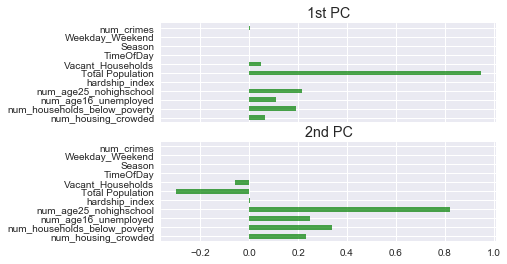

In [72]:
# Plotting PCs
comp = pd.DataFrame(pca.components_, columns=crimeDR.columns, index=['pc1','pc2'])
fig, axes = plt.subplots(2,1,sharex=True)
comp.loc['pc1'].plot(kind='barh',ax=axes[0],color='g',alpha=0.7)
axes[0].set_title('1st PC', size='x-large')
comp.loc['pc2'].plot(kind='barh',ax=axes[1],color='g',alpha=0.7)
axes[1].set_title('2nd PC', size='x-large')

In [73]:
# Printing components
comp = pd.DataFrame(pca.components_, columns=crimeDR.columns, index=['pc1','pc2'])
comp

,num_housing_crowded,num_households_below_poverty,num_age16_unemployed,num_age25_nohighschool,hardship_index,Total Population,Vacant_Households,TimeOfDay,Season,Weekday_Weekend,num_crimes
pc1,0.065953,0.192133,0.110498,0.215971,-0.000127,0.947344,0.049127,0.000003,0.000009,-0.000001,0.002658
pc2,0.232289,0.339467,0.248035,0.822631,0.003517,-0.298424,-0.059087,0.000059,-0.000042,-0.000013,-0.000500


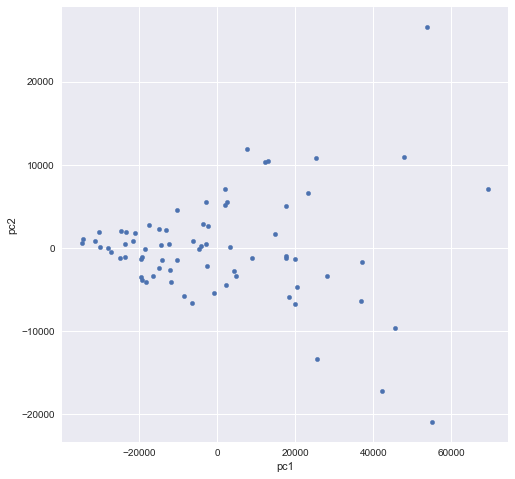

In [74]:
projected.plot(kind='scatter',x='pc1',y='pc2', figsize=(8,8))

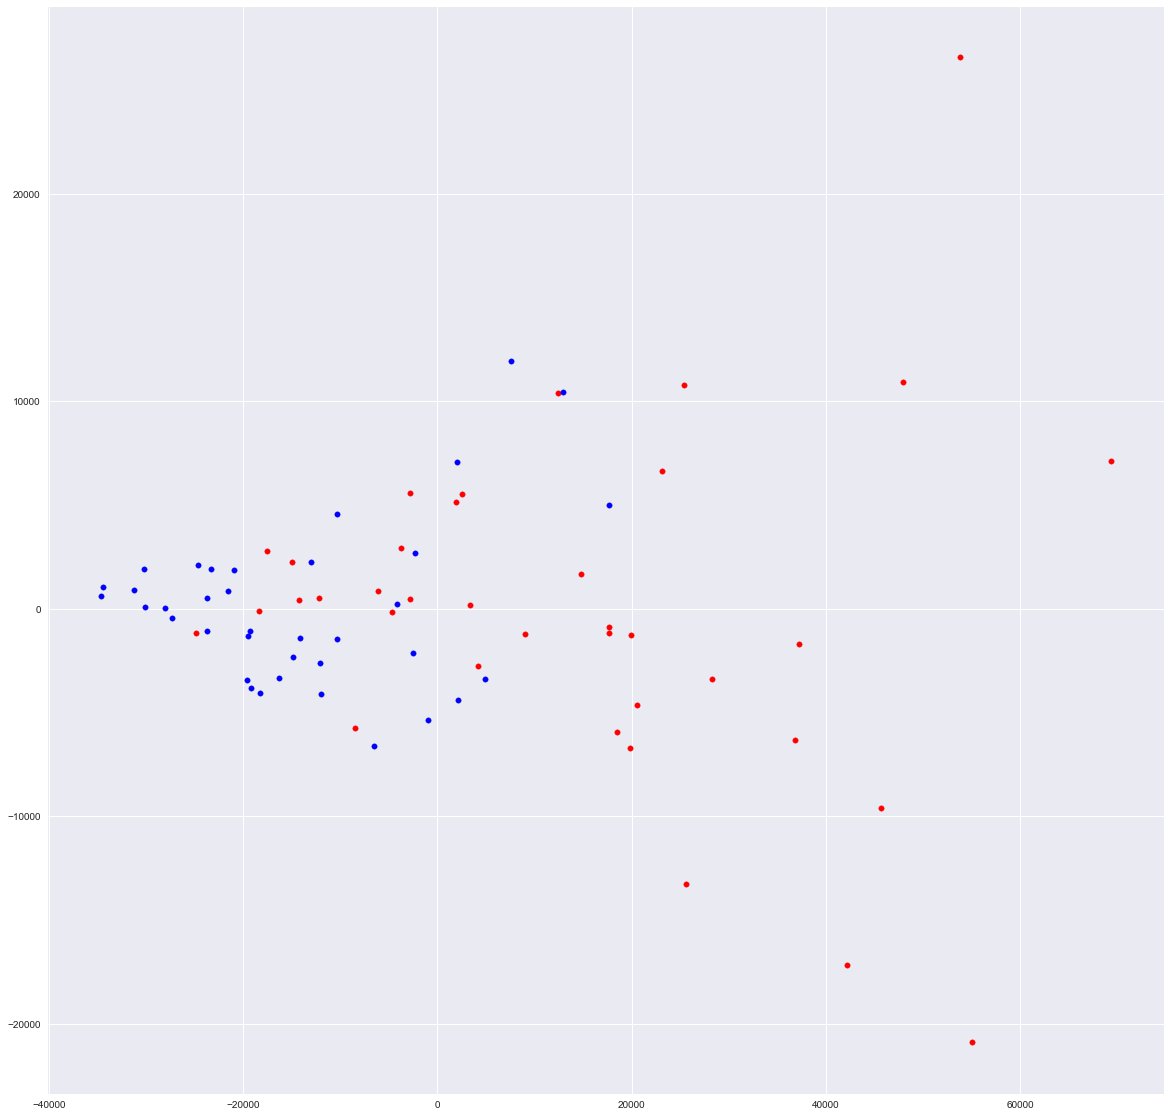

In [92]:
# The half of community areas with the most crimes
mostCrimeCities = PrimaryCrimeTypeCounts.sum(axis=1)
mostCrimeCities = mostCrimeCities.sort_values(ascending=False)
mostCrimeCities = mostCrimeCities.index.tolist()
mostCrimeCities = mostCrimeCities[:37]

plt.figure(figsize=(20,20))
for index, row in projected.iterrows():
    if index in x:
        
        plt.scatter(row['pc1'], row['pc2'], c = 'r', s= 30) # Community areas with more crime
    else:
        plt.scatter(row['pc1'], row['pc2'], c = 'b', s= 30) # Community areas with less crime
        
plt.show()

# Regression

In [93]:
# Our goal is to predict "num_crimes" (target attribute) based on the rest of the columns in the data frame
Y = crimeDR['num_crimes']
X = crimeDR.drop(columns=['num_crimes'])
X.head()

,num_housing_crowded,num_households_below_poverty,num_age16_unemployed,num_age25_nohighschool,hardship_index,Total Population,Vacant_Households,TimeOfDay,Season,Weekday_Weekend
Community_Name,,,,,,,,,,
AVALON PARK,142.590,1751.820,2149.035,1079.610,41.0,10185.0,371.0,1,1,1
WASHINGTON HEIGHTS,291.423,4477.317,5510.544,3629.541,48.0,26493.0,883.0,4,4,0
ASHBURN,1643.240,4272.424,4806.477,7271.337,37.0,41081.0,609.0,2,2,1
WOODLAWN,688.460,7288.180,5555.160,3917.100,58.0,23740.0,2714.0,3,4,0
LOOP,439.245,4304.601,1669.131,907.773,3.0,29283.0,5063.0,1,3,0


In [94]:
# split training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

Root mean squared error = 52.3933
R-square = 0.5522
Linear Regression Accuracy:  55.22 %
***************************
Slope Coefficients: [ 1.25573150e-02  4.22435731e-03  1.20645345e-02 -6.47498520e-03
  8.18305819e-02 -7.63339896e-06  2.15354359e-02 -2.99172245e+00
  3.81152029e+00  2.20124052e+01]
Intercept: -28.99169758991998


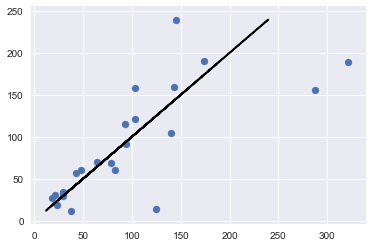

In [95]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Fit regression model to the training set
regr.fit(X_train, y_train)

# Apply model to the test set
y_pred_test = regr.predict(X_test)
accuracy = regr.score(X_test,y_test)

print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R-square = %.4f" % r2_score(y_test, y_pred_test))
print("Linear Regression Accuracy: ",round(accuracy*100,2),'%')
print("***************************")
print('Slope Coefficients:', regr.coef_)
print('Intercept:', regr.intercept_)

# plot the linear line thru the scatter plot 
plt.plot(y_pred_test, m*y_pred_test + b,color='black')
plt.scatter(y_test,y_pred_test)

In [37]:
# Regression Model
print("y = ", end="")
for i in range(len(X.columns)):
    print(str(regr.coef_[i]) + "*" + X.columns[i] + " + ", end="")
print(regr.intercept_)

y = 0.012557315046053515*num_housing_crowded + 0.00422435731305109*num_households_below_poverty + 0.012064534524246108*num_age16_unemployed + -0.0064749852044095136*num_age25_nohighschool + 0.08183058189618535*hardship_index + -7.633398956054837e-06*Total Population + 0.021535435854367915*Vacant_Households + -2.991722454831263*TimeOfDay + 3.8115202861095345*Season + 22.01240517904716*Weekday_Weekend + -28.99169758991998


In [38]:
# Testing the model
predicted = dict()
for index, row in X.iterrows():
    total = 0
    for c in range(len(X.columns)):
        total += regr.coef_[c] * row[X.columns[c]]
    predicted[index] = total
    
predicted = {k: v for k, v in sorted(predicted.items(), reverse=True, key=lambda item: item[1])}

print(predicted)

{'AUSTIN': 463.18345097191064, 'NEAR NORTH SIDE': 373.4671166644873, 'SOUTH SHORE': 313.1908391712155, 'WEST ENGLEWOOD': 268.49282439660277, 'AUBURN GRESHAM': 268.06716302981175, 'HUMBOLDT PARK': 263.4501621400491, 'ENGLEWOOD': 235.2261396210557, 'NEW CITY': 219.63909440458755, 'NEAR WEST SIDE': 218.4592616403559, 'NORTH LAWNDALE': 216.4322819016776, 'LAKE VIEW': 208.98835443541927, 'EDGEWATER': 201.0163370544254, 'CHATHAM': 195.01079612350813, 'CHICAGO LAWN': 192.28426577728385, 'BELMONT CRAGIN': 188.1198842779475, 'SOUTH LAWNDALE': 187.1724456933632, 'WEST RIDGE': 186.65523433436348, 'WEST TOWN': 184.77921937029234, 'LOGAN SQUARE': 182.43894303153442, 'ROSELAND': 180.86936343874348, 'ROGERS PARK': 179.5967542029074, 'GREATER GRAND CROSSING': 171.27685832549523, 'EAST GARFIELD PARK': 156.74376574548108, 'LOOP': 155.4580954507683, 'LINCOLN PARK': 155.44467064979108, 'UPTOWN': 155.31613529172833, 'WOODLAWN': 150.37338420941808, 'PORTAGE PARK': 149.60497087619794, 'GRAND BOULEVARD': 144.

In [96]:
# actual crime numbers by community area
actual = PrimaryCrimeTypeCounts.sum(axis=1)
actual = actual.sort_values(ascending=False)

actualValues= actual.tolist()
actualNames = actual.index.tolist()
actual = dict(zip(actualNames, actualValues))

# dataframe to compare predicted and actual crime numbers
comparison = pd.DataFrame(columns=['Actual', 'Predicted', 'Difference', 'Difference (abs)'], index=actualNames)

for key, value in predicted.items() :
    comparison.at[key, 'Actual'] = actual[key]
    comparison.at[key, 'Predicted'] = predicted[key]
    comparison.at[key, 'Difference'] = actual[key] - predicted[key]
    comparison.at[key, 'Difference (abs)'] = abs(actual[key] - predicted[key])

# difference between actual & predicted amount of crimes
difference = comparison['Difference'].sum()
differenceAbs = comparison['Difference (abs)'].sum()


comparison

,Actual,Predicted,Difference,Difference (abs)
AUSTIN,517,463.183,53.8165,53.8165
NEAR NORTH SIDE,338,373.467,-35.4671,35.4671
NEAR WEST SIDE,321,218.459,102.541,102.541
WEST TOWN,287,184.779,102.221,102.221
HUMBOLDT PARK,275,263.45,11.5498,11.5498
NORTH LAWNDALE,237,216.432,20.5677,20.5677
SOUTH SHORE,217,313.191,-96.1908,96.1908
LOOP,203,155.458,47.5419,47.5419
LAKE VIEW,191,208.988,-17.9884,17.9884
LOGAN SQUARE,179,182.439,-3.43894,3.43894


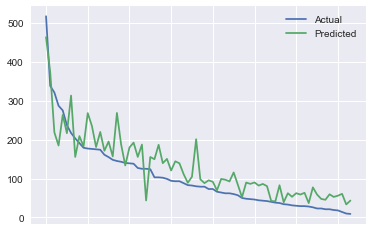

In [102]:
comparison[['Actual','Predicted']].plot.line()